<a href="https://colab.research.google.com/github/roxyrong/w281-project/blob/main/feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#from google.colab import drive
#drive.mount("/content/drive")

time: 0 ns (started: 2023-12-15 16:44:00 -08:00)


In [6]:
%%capture
%pip install ipython-autotime seaborn tensorflow pyarrow tqdm ipywidgets tabulate

time: 2.86 s (started: 2023-12-15 16:44:00 -08:00)


In [7]:

import os
import time
import copy
import gc
import datetime
from glob import glob
import numpy as np
from numpy import fft
import pandas as pd
import sklearn
from tqdm.notebook import tqdm_notebook


from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from skimage.feature import hog, canny
from skimage import exposure
from scipy.cluster.vq import kmeans, vq
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

import cv2
from PIL import Image, ImageStat

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from IPython.display import display, HTML


tqdm_notebook.pandas()      

time: 0 ns (started: 2023-12-15 16:44:03 -08:00)


# Data Loading & Cleaning

In [4]:
def load_dataset(datapath):
    df = pd.DataFrame()

    for folder in os.listdir(datapath):
      files = glob(pathname= str(datapath + folder + "/*.jpg"))
      df = pd.concat([df, pd.DataFrame( { "filename": files ,
                                          "category": folder} ) ])
    df = df.reset_index(drop=True)

    def load_image(row):
      img = Image.open(row["filename"])
      row['resolution'] = img.size
      
      if img.size == (150,150):
        row['image'] = np.array(img, dtype=np.uint8).flatten()
        
        row['hsv_image'] =  np.array(img.convert("HSV")).flatten()
        row['gray_image'] = np.array(img.convert("L")).flatten()
        
      return row

    df = df.progress_apply(load_image, axis=1)

    df.drop(df[df.resolution != (150,150)].index, inplace=True)

    return df

def load_dataset_parquet(datapath):
    df = pd.read_parquet(datapath)
    return df

def unflatten_image(row, image, dim):
  
   row[image] = row[image].reshape(dim).astype("uint8")
   return row
 

time: 0 ns (started: 2023-12-15 16:42:50 -08:00)


In [ ]:
test_parquet_path = "dataset/test_df.parquet.gzip"
train_parquet_path = "dataset/train_df.parquet.gzip"


if not os.path.exists(test_parquet_path):
  # load directly
  train_path = "dataset/seg_train/seg_train/"
  test_path = "dataset/seg_test/seg_test/"
  train_df = load_dataset(train_path)
  test_df = load_dataset(test_path)

  # save to parquet locally
  train_df.to_parquet(train_parquet_path,compression="gzip")
  test_df.to_parquet(test_parquet_path,compression="gzip")
else:
  train_df = load_dataset_parquet(train_parquet_path)
  test_df = load_dataset_parquet(test_parquet_path)

train_df = train_df.progress_apply(unflatten_image, axis=1, image="image", dim=(150,150,3))
train_df = train_df.progress_apply(unflatten_image, axis=1, image="gray_image", dim=(150,150))
train_df = train_df.progress_apply(unflatten_image, axis=1, image="hsv_image", dim=(150,150,3))

test_df = test_df.progress_apply(unflatten_image, axis=1, image="image", dim=(150,150,3))
test_df = test_df.progress_apply(unflatten_image, axis=1, image="gray_image", dim=(150,150))
test_df = test_df.progress_apply(unflatten_image, axis=1, image="hsv_image", dim=(150,150,3))

gc.collect()

# Feature Engineering

### RGB Feature (unused in final analysis)

In [ ]:
## RGB feature
def add_rgb_feature(row):
    r, g, b = np.mean(row["image"], axis=(0, 1))
    row["mean_r"] = r
    row["mean_g"] = g
    row["mean_b"] = b

    return row

time: 0 ns (started: 2023-12-14 04:55:42 -08:00)


### Color Information Feature (HSV Histogram and Stats)

In [ ]:
## HSV feature
def add_hsv_feature(row):
    image = Image.fromarray(row["hsv_image"].astype("uint8"))
    hsv_stats = ImageStat.Stat(image)

    row["mean_h"] = hsv_stats.mean[0]
    row["mean_s"] = hsv_stats.mean[1]
    row["mean_v"] = hsv_stats.mean[2]

    row["stddev_h"] = hsv_stats.stddev[0]
    row["stddev_s"] = hsv_stats.stddev[1]
    row["stddev_v"] = hsv_stats.stddev[2]

    row["hsv_histogram"] = np.array(image.histogram())

    return row

time: 0 ns (started: 2023-12-14 04:55:42 -08:00)


### HOG feature

In [ ]:

def add_hog_feature(row):
  row["hog_feature"], row["hog_image"] = hog(row["gray_image"],
                                             orientations=8,
                                             pixels_per_cell=(15, 15),
                                             cells_per_block=(1, 1),
                                             visualize=True)

  return row

time: 0 ns (started: 2023-12-14 04:55:42 -08:00)


### Canny Feature

In [ ]:

def add_canny_feature(row):
  row["canny_feature"] = canny(row["gray_image"], sigma=2).flatten()
  return row

time: 0 ns (started: 2023-12-14 04:55:42 -08:00)


### Fourier feature 

In [ ]:

def add_fourier_feature(row):
  image = row["gray_image"]
  ydim = image.shape[0]
  xdim = image.shape[1]
  win = np.outer(np.hanning(ydim), np.hanning(xdim))
  win = win/np.mean(win)
  fourier = fft.fftshift(fft.fft2(image * win))
  Fmag = np.abs(fourier)
  row["fourier_feature"] = np.log(Fmag).flatten()
  return row

time: 0 ns (started: 2023-12-14 04:55:42 -08:00)


### Bag of Visual Words

In [ ]:


def add_bag_of_visual_word_feature(train_df, test_df,training_timer):
    extractor = cv2.xfeatures2d.SIFT_create()
    k = 200 # number of visual words

    def add_sift(row):
        img = row["gray_image"]
        img_keypoints, img_descriptors = extractor.detectAndCompute(img, None)
        row["keypoint"] = img_keypoints
        row["descriptor"] = img_descriptors
        return row

    def add_visual_words(row):
        img_descriptors = row["descriptor"]
        img_visual_words = []
        if img_descriptors is not None:
          img_visual_words, distance = vq(img_descriptors, codebook)
          row["visual_word"] = img_visual_words

        img_frequency_vector = np.zeros(k)
        for word in img_visual_words:
            img_frequency_vector[word] += 1
        row["frequency_vector"] = img_frequency_vector
        return row

    # creating codebook for visual words
    training_timer.start('bag_of_words')
    train_df = train_df.apply(add_sift, axis=1)
    
    sample_index = train_df[train_df["descriptor"].notna()].sample(frac=0.2).index
    all_descriptors = np.vstack(train_df.loc[sample_index]["descriptor"].to_numpy())
    codebook, variance = kmeans(all_descriptors, k, 1)

    # compute tfidf
    train_df = train_df.apply(add_visual_words, axis=1)
    training_timer.stop('bag_of_words')
    
    test_df = test_df.apply(add_sift, axis=1)
    test_df = test_df.apply(add_visual_words, axis=1)

    train_frequency_vectors = np.vstack(train_df["frequency_vector"])
    test_frequency_vectors = np.vstack(test_df["frequency_vector"])
    idf = np.log(len(train_df) / np.sum(train_frequency_vectors > 0, axis=0))
    train_tfidf =  train_frequency_vectors * idf
    test_tfidf = test_frequency_vectors * idf
    train_df["bag_of_visual_words"] = list(train_tfidf)
    test_df["bag_of_visual_words"] = list(test_tfidf)
    return train_df, test_df

time: 0 ns (started: 2023-12-14 04:55:43 -08:00)


In [ ]:
#########################################################
# Feature Extraction Begins Below
#########################################################
class MyTimer:
    
    def __init__(self):
        self.data = pd.DataFrame()
        
    def start(self,name):
        if name in self.data.index:
            self.data.at[name,'duration'] = 0
            self.data.at[name,'start'] = datetime.datetime.now()
        else:
            self.data = pd.concat( [ self.data, pd.DataFrame({ 'start' : datetime.datetime.now(), 'duration' : 0.}, index=[name] ) ] )

    def stop(self,name):
        self.data.at[name,'duration'] = (datetime.datetime.now() - self.data.at[name,'start']).total_seconds()
        
    def report(self):
        display(self.data)


training_timer = MyTimer()



time: 31 ms (started: 2023-12-14 04:59:35 -08:00)


In [15]:
#RGB
training_timer.start('add_rgb_feature')
train_df = train_df.progress_apply(add_rgb_feature, axis=1) # 52 sec
training_timer.stop('add_rgb_feature')

test_df = test_df.progress_apply(add_rgb_feature, axis=1) # 13 sec

gc.collect()

  0%|          | 0/13986 [00:00<?, ?it/s]

  0%|          | 0/2993 [00:00<?, ?it/s]

34

time: 39.2 s (started: 2023-12-14 04:59:35 -08:00)


In [16]:
#HSV (768, 0)
training_timer.start('add_hsv_feature')
train_df = train_df.progress_apply(add_hsv_feature, axis=1) # 52 sec
training_timer.stop('add_hsv_feature')
test_df = test_df.progress_apply(add_hsv_feature, axis=1) # 13 sec

#filter out black & white images
train_df = train_df[train_df["mean_h"] > 5]
test_df = test_df[test_df["mean_h"] > 5]

gc.collect()

  0%|          | 0/13986 [00:00<?, ?it/s]

  0%|          | 0/2993 [00:00<?, ?it/s]

34

time: 1min (started: 2023-12-14 05:00:14 -08:00)


In [1]:
#VGG16 (8192, 0)
vgg_model = VGG16(include_top=False, input_shape=(150, 150, 3))

training_timer.start('vgg16')
train_df["vgg_input"] = train_df["image"].progress_apply(preprocess_input)
train_df["vgg16_feature"] = list(vgg_model.predict(np.stack(train_df["vgg_input"].to_numpy()),
                                                 verbose=False).reshape(len(train_df), -1))

train_df.drop(columns=['vgg_input'], inplace=True)
training_timer.stop('vgg16')
gc.collect()

test_df["vgg_input"] = test_df["image"].progress_apply(preprocess_input)
test_df["vgg16_feature"] = list(vgg_model.predict(np.stack(test_df["vgg_input"].to_numpy()),
                                                 verbose=False).reshape(len(test_df), -1))
test_df.drop(columns=['vgg_input'], inplace=True)

gc.collect()

NameError: name 'VGG16' is not defined

In [18]:
#HOG: shape = (800, 0)
training_timer.start('hog')
train_df = train_df.progress_apply(add_hog_feature, axis=1)  # 211 sec
training_timer.stop('hog')

test_df = test_df.progress_apply(add_hog_feature, axis=1) # 44 sec

gc.collect()

  0%|          | 0/13359 [00:00<?, ?it/s]

  0%|          | 0/2853 [00:00<?, ?it/s]

34

time: 4min 28s (started: 2023-12-14 05:09:20 -08:00)


In [19]:
#plt.imshow(exposure.rescale_intensity(train_df.iloc[100]["hog_image"], in_range=(0, 10)),cmap=plt.cm.gray )

time: 0 ns (started: 2023-12-14 05:13:48 -08:00)


In [62]:
#Canny: shape = (150, 150) Not using due to low performance
training_timer.start('canny')
train_df = train_df.progress_apply(add_canny_feature, axis=1) # 64 sec
training_timer.stop('canny')
test_df = test_df.progress_apply(add_canny_feature, axis=1) # 13 sec

gc.collect()

  0%|          | 0/13359 [00:00<?, ?it/s]

  0%|          | 0/2853 [00:00<?, ?it/s]

34

time: 41.8 s (started: 2023-12-14 06:13:20 -08:00)


In [21]:
#HED shape = (150, 150, 3) Not using due to long runtime
# train_df["blob"] = blob_batch_processing(train_df["image"])
# train_df = train_df.apply(add_HED_feature, axis=1)
# test_df = test_df.apply(add_HED_feature, axis=1)

time: 0 ns (started: 2023-12-14 05:13:48 -08:00)


In [22]:
#fourier: shape = (150, 150)
training_timer.start('fourier')
train_df = train_df.progress_apply(add_fourier_feature, axis=1)
training_timer.stop('fourier')
test_df = test_df.progress_apply(add_fourier_feature, axis=1)

gc.collect()

  0%|          | 0/13359 [00:00<?, ?it/s]

  0%|          | 0/2853 [00:00<?, ?it/s]

34

time: 22.2 s (started: 2023-12-14 05:13:48 -08:00)


In [23]:
# bag of visual words
train_df, test_df = add_bag_of_visual_word_feature(train_df, test_df, training_timer)

gc.collect()

0

time: 5min 55s (started: 2023-12-14 05:14:10 -08:00)


# Timing Report

In [63]:
training_timer.report()

start    duration
add_rgb_feature 2023-12-14 04:59:35.111022   33.425562
add_hsv_feature 2023-12-14 05:00:14.402569   51.203185
vgg16           2023-12-14 05:01:15.944063  402.454787
hog             2023-12-14 05:09:20.106000  222.706311
fourier         2023-12-14 05:13:48.522228   18.204716
bag_of_words    2023-12-14 05:14:10.765506  325.637741
canny           2023-12-14 06:13:20.159146   34.568483

time: 16 ms (started: 2023-12-14 06:15:23 -08:00)


# Feature Selection

In [25]:
def pca_analysis(df, feature_dimensions):
    explained_variance_dict = {}

    for feature, num_component in feature_dimensions.items():
        print(feature)
        feature_vector = np.stack(df[feature].to_numpy())

        explained_variance = []
        max_components = min(num_component, len(df))

        for components in range(5, max_components + 1, 5):
            pca = PCA(n_components=components)
            pca.fit(feature_vector)
            total_variance = np.sum(pca.explained_variance_ratio_)
            explained_variance.append(total_variance)

        explained_variance_dict[feature] = explained_variance

    return explained_variance_dict


def pca_analysis_plot(explained_variance_dict):
    plt.figure(figsize=(10, 6))

    for feature, variances in explained_variance_dict.items():
        plt.plot([i * 5 for i in range(1, len(variances) + 1)],
                 variances,
                 label=feature)

    plt.title("Explained Variance by Feature from PCA Analysis")
    plt.xlabel("Component Number")
    plt.ylabel("Explained Variance")
    plt.legend()
    plt.show()

time: 15 ms (started: 2023-12-14 05:20:06 -08:00)


In [26]:
feature_dimensions = {
    "hsv_histogram" : 768,
    "hog_feature": 800,
    "canny_feature": 22500,
    "vgg16_feature": 8192,
    "fourier_feature": 22500,
    "bag_of_visual_words": 200
}

#explained_variance_dict = pca_analysis(train_df.sample(700),
                                      #  feature_dimensions)

#pca_analysis_plot(explained_variance_dict)

SyntaxError: incomplete input (3968192717.py, line 13)

time: 16 ms (started: 2023-12-14 05:20:06 -08:00)


In [27]:
feature_pca_components = {
    "hsv_histogram" : 50,
    "hog_feature": 100,
    "vgg16_feature": 200,
    "fourier_feature": 25,
    "bag_of_visual_words": 40
}

pca_features = [f"pca_{feature}" for feature in feature_pca_components.keys()]
print(pca_features)

['pca_hsv_histogram', 'pca_hog_feature', 'pca_vgg16_feature', 'pca_fourier_feature', 'pca_bag_of_visual_words']
time: 0 ns (started: 2023-12-14 05:29:46 -08:00)


In [28]:
def apply_pca(train_df, test_df, feature_pca_components):
    for feature, num_component in feature_pca_components.items():
        pca = PCA(n_components=num_component)
        pca.fit(np.stack(train_df[feature].to_numpy()))
        train_df[f"pca_{feature}"] = list(pca.transform(np.stack(train_df[feature].to_numpy())))
        print(feature, np.sum(pca.explained_variance_ratio_))
        test_df[f"pca_{feature}"] = list(pca.transform(np.stack(test_df[feature].to_numpy())))
    return train_df, test_df

train_df, test_df = apply_pca(train_df, test_df, feature_pca_components)

gc.collect()

hsv_histogram 0.8734476960852129
hog_feature 0.6738427407955834
vgg16_feature 0.5704114
fourier_feature 0.4756623834012086
bag_of_visual_words 0.7050034541075746


0

time: 48.2 s (started: 2023-12-14 05:29:49 -08:00)


In [31]:
train_features_path = "dataset/train_features_full.parquet.gzip"
test_features_path = "dataset/test_features_full.parquet.gzip"

features = ["mean_r", "mean_g", "mean_b", "mean_h", "mean_s", "mean_v", "stddev_h", "stddev_s", "stddev_v",
            "pca_hsv_histogram", "pca_hog_feature", "pca_vgg16_feature",
            "pca_fourier_feature", "pca_bag_of_visual_words"]

train_features_df = train_df[features + ["category", "image"]].copy()
for idx, row in train_features_df.iterrows():
  train_features_df.at[idx, "image"] = train_features_df.at[idx, "image"].flatten()
train_features_df.to_parquet(train_features_path, compression="gzip")

test_features_df = test_df[features + ["category", "image"]]
for idx, row in test_features_df.iterrows():
    test_features_df.at[idx, "image"] = test_features_df.at[idx, "image"].flatten()
test_features_df.to_parquet(test_features_path, compression="gzip")

time: 1min 19s (started: 2023-12-14 05:35:11 -08:00)


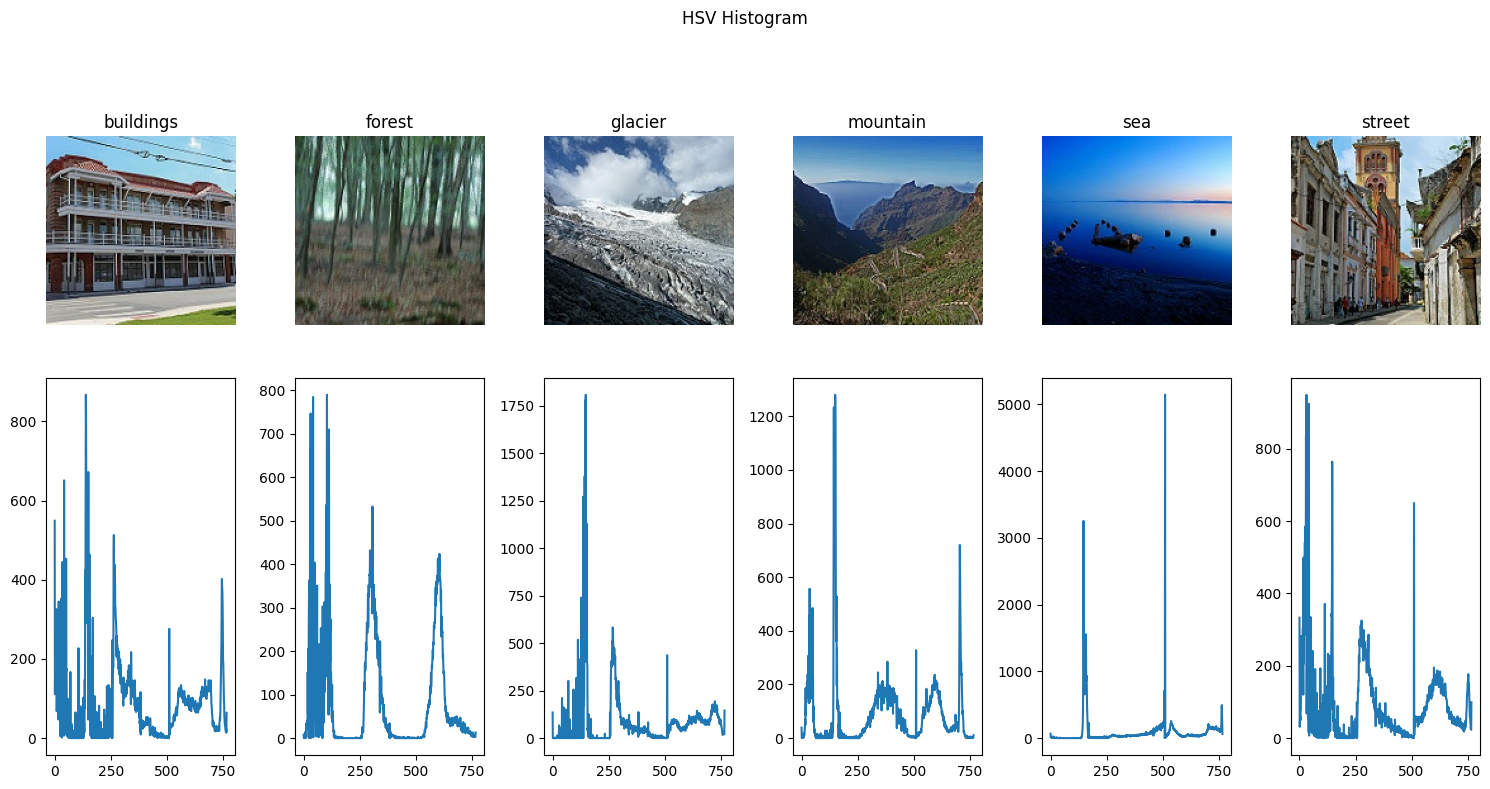

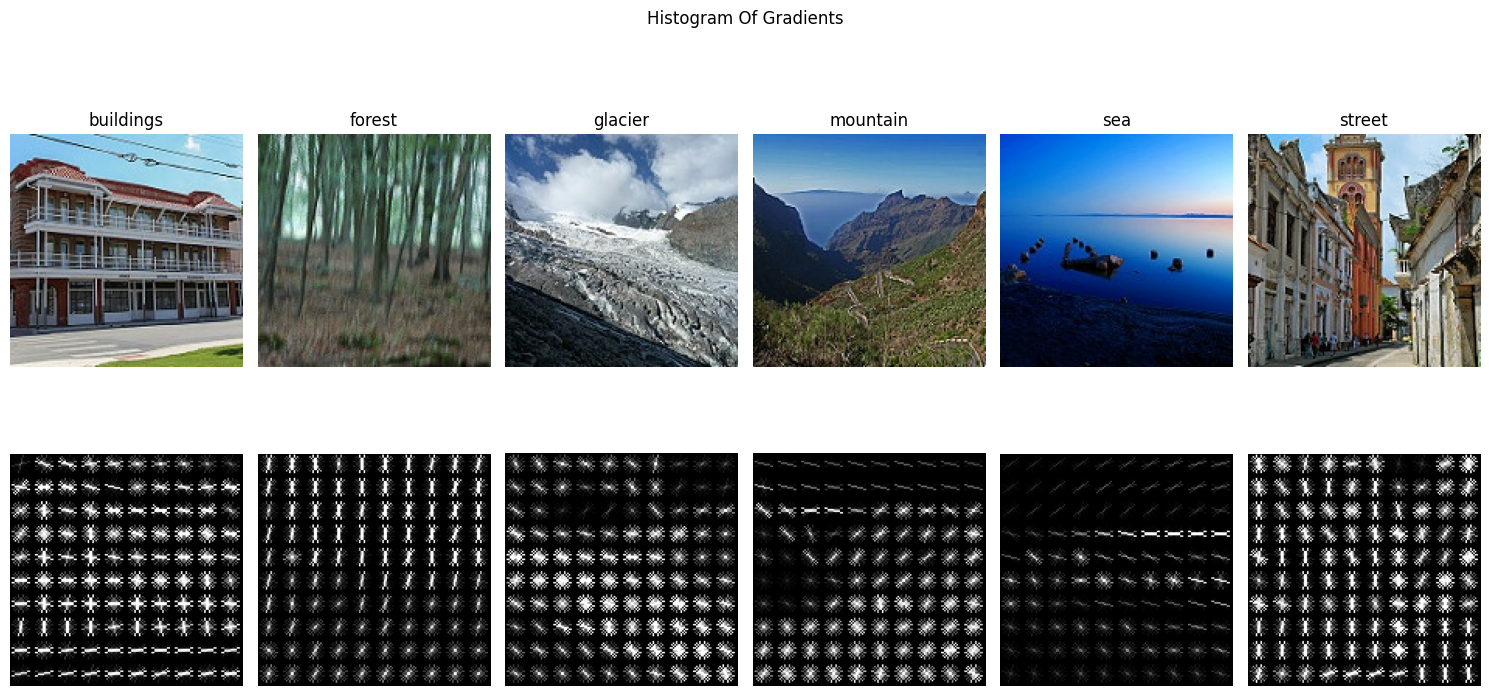

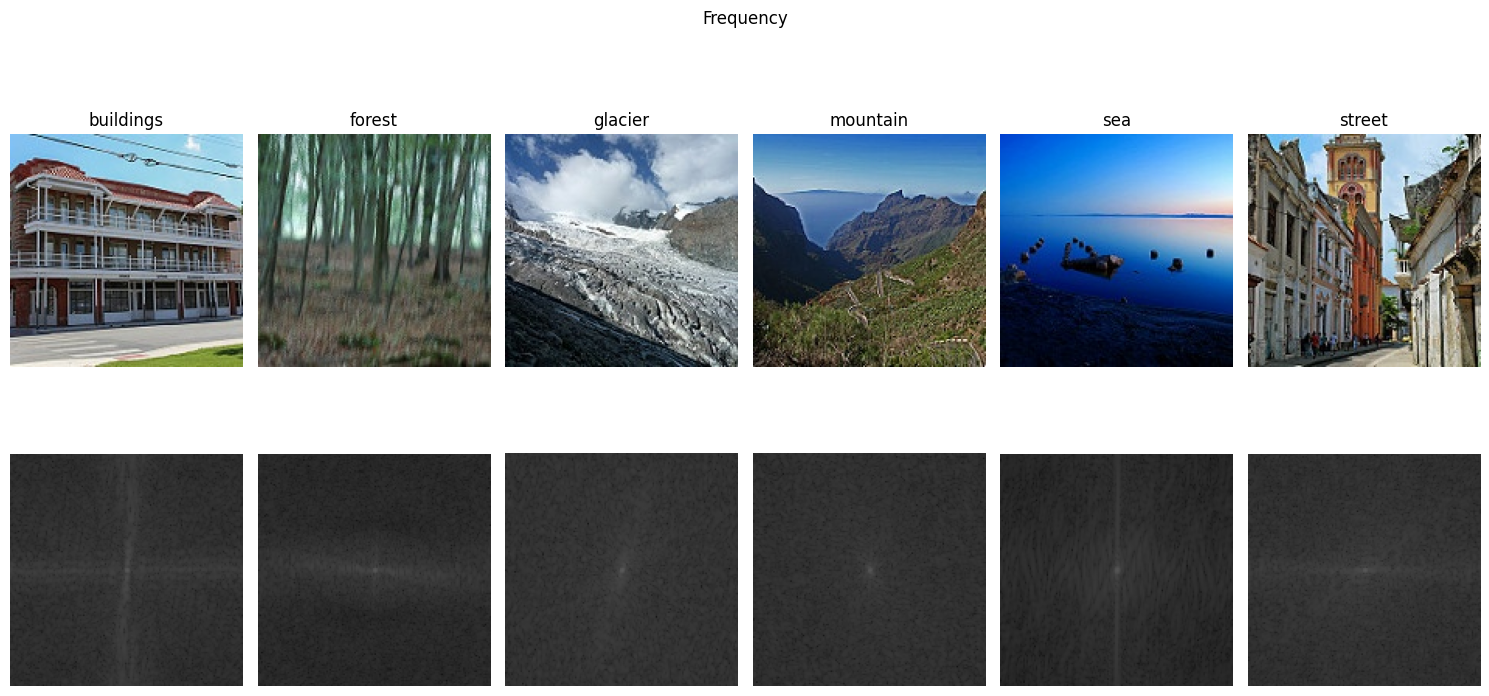

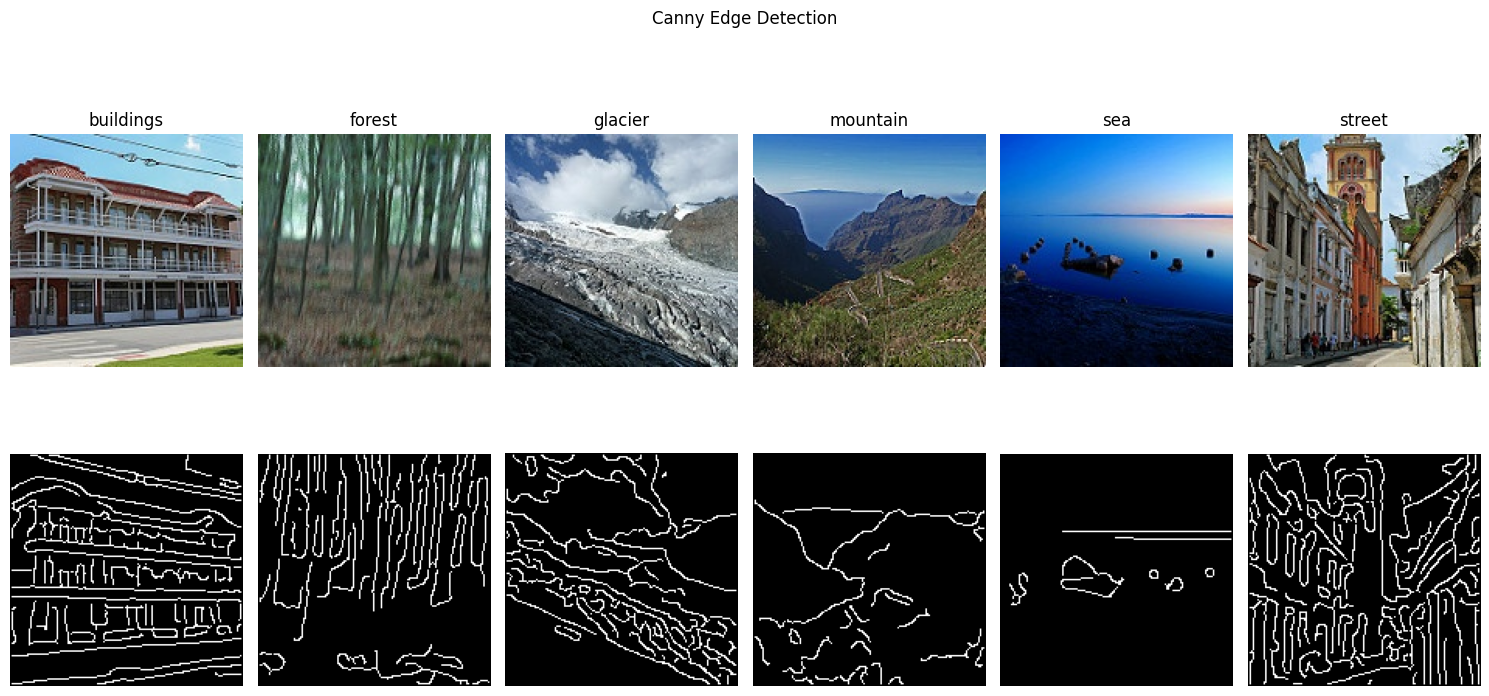

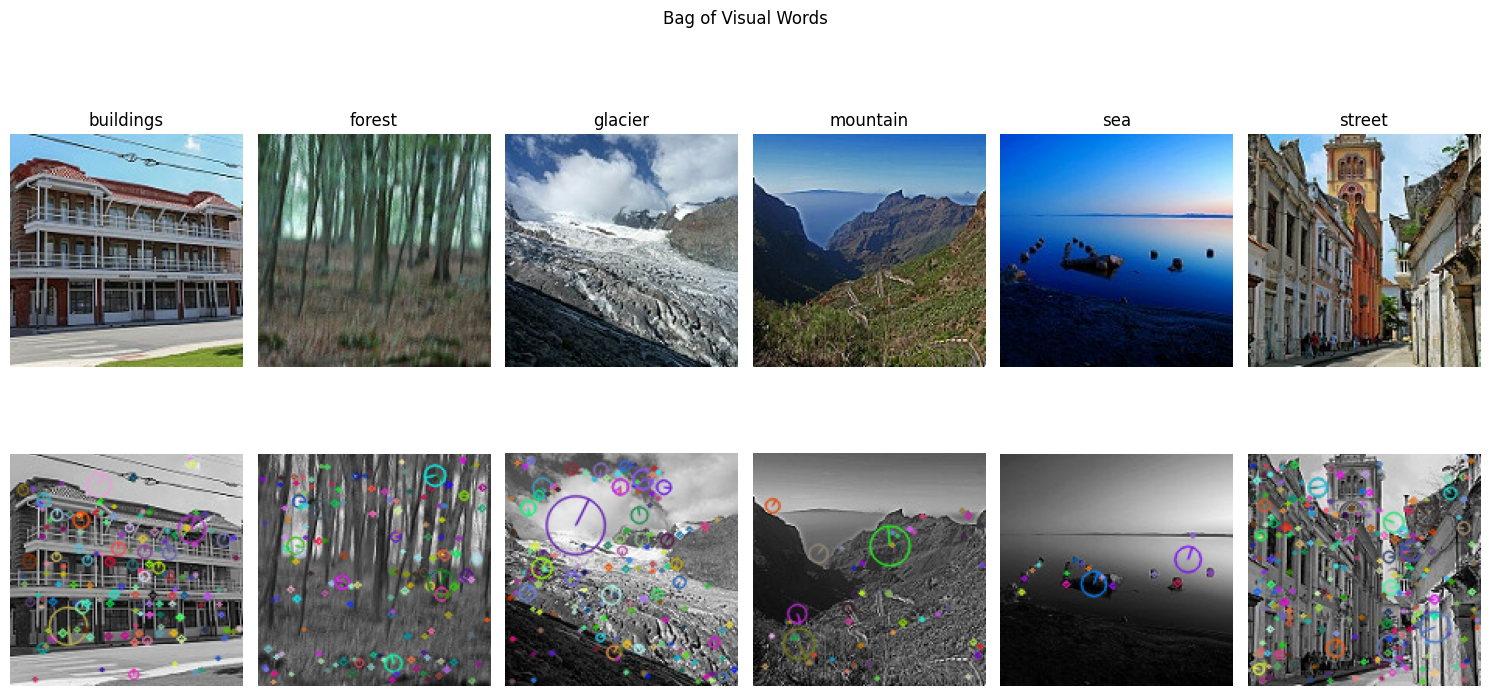

time: 4.66 s (started: 2023-12-14 16:35:16 -08:00)


In [75]:


for feature in [ 'hsv', 'hog', 'fourier','canny','bovw']:
    
    fig, ax = plt.subplots(2, 6, figsize=(15,8))
    for idx,row in train_df.groupby('category').nth(2).reset_index().iterrows():
        category = row['category']
        img = Image.fromarray(row['image'])
        ax[0][idx].imshow(img)
        ax[0][idx].axis('off')
        ax[1][idx].axis('off')
        ax[0][idx].set_title(category)
        
        if feature == 'hsv':
            plt.suptitle("HSV Histogram")
            ax[1] [idx].plot(row['hsv_histogram'])
            ax[1][idx].axis('on')
        if feature == 'hog':
            plt.suptitle("Histogram Of Gradients")
            ax[1][idx].imshow(exposure.rescale_intensity(row["hog_image"], in_range=(0, 10)),
                               cmap=plt.cm.gray )
        if feature == 'fourier':
            plt.suptitle("Frequency")
            ax[1][idx].imshow( Image.fromarray(row['fourier_feature'].reshape((150,150)) * 6) ,
                       cmap=plt.cm.gray )
        if feature == 'canny':
            plt.suptitle("Canny Edge Detection")
            ax[1][idx].imshow( Image.fromarray(row['canny_feature'].reshape((150,150)) * 256) ,
                       cmap=plt.cm.gray )
        if feature == 'bovw':
            plt.suptitle("Bag of Visual Words")
            out = row['gray_image'].copy()
            out=cv2.drawKeypoints(row['gray_image'] ,
                            row['keypoint'] ,
                            out ,
                            flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            ax[1][idx].imshow(out)
        
    plt.tight_layout()
    plt.show()

  
